In [83]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import random
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import AutoModel, BertTokenizerFast, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [2]:
with open('mycareersfuture.json') as json_file:
    data = json.load(json_file)

all_skills = []
for job in data['jobs']:
    all_skills = all_skills + list(job['skills_required'])


In [3]:
def removeUnfrequentSkill(i_list, threshold):

    unique_set = set(i_list)
    unique_list = (list(unique_set))
    
    item_counts = {}
    for item in unique_set:
        item_counts[item] = i_list.count(item)

    r_list = []
    for key, value in item_counts.items():
        if value >= threshold and key != 'a':
            r_list.append(key)

    return r_list

In [132]:
all_categories = []
for job in data['jobs']:
    if (job['job_category']!="not_available"):
        temp_cat = []
        for cat in  job['job_category']:
            temp_cat = temp_cat + cat.replace(' ','').split(",")
        all_categories = all_categories + temp_cat
unique_set = set(all_categories)
unique_list = (list(unique_set))

item_counts = {}
for item in unique_set:
    item_counts[item] = all_categories.count(item)

In [135]:
item_counts

{'Beauty': 135,
 'Public': 613,
 'Merchandising': 176,
 'Advertising': 424,
 'F&B': 954,
 'HumanResources': 609,
 'Marketing': 828,
 'Accounting': 1187,
 'Tourism': 106,
 'Environment': 136,
 'Healthcare': 656,
 'BankingandFinance': 1275,
 'Retail': 1378,
 'Entertainment': 60,
 'SocialServices': 103,
 'Travel': 106,
 'Health': 136,
 'Engineering': 2627,
 'RiskManagement': 79,
 'PublicRelations': 828,
 'Consulting': 623,
 'Medical': 153,
 'Sciences': 741,
 'Promotions': 176,
 'Logistics': 714,
 'TherapyServices': 153,
 'Hospitality': 305,
 'Pharmaceutical': 656,
 'CivilService': 613,
 'ProfessionalServices': 325,
 'RepairandMaintenance': 209,
 'Auditing': 1187,
 'InteriorDesign': 359,
 'EducationandTraining': 648,
 'CustomerService': 861,
 'PersonalCare': 135,
 'InformationTechnology': 4561,
 'SupplyChain': 714,
 'Media': 424,
 'Events': 176,
 'Others': 1178,
 'Manufacturing': 705,
 'Laboratory': 741,
 'Insurance': 185,
 'PropertyManagement': 161,
 'Design': 339,
 'Secretarial': 1146,
 

In [54]:
item_counts['Operational Risk Management']

28

In [169]:
skills = removeUnfrequentSkill(all_skills,3010)

In [73]:
skills = removeUnfrequentSkill(all_skills,20)

In [74]:
len(skills)

1209

In [170]:
id2label = {idx:label for idx, label in enumerate(skills)}
label2id = {label:idx for idx, label in enumerate(skills)}

In [218]:
text_data = []
label_data = []
for job in data['jobs']:
    job_text = job['requirements_and_role'] + ' ' + job['job_requirements']
    skill_required = [float(0)] * len(skills)
    for skill in job['skills_required']:
        if skill in skills:
            skill_required[skills.index(skill)] = float(1)
    text_data.append(job_text)
    label_data.append(skill_required)

In [137]:
categories = []
for job in data['jobs']:
    if (job['job_category']!="not_available"):
        temp_cat = []
        for cat in  job['job_category']:
            temp_cat = temp_cat + cat.replace(' ','').split(",")
        categories = categories + temp_cat
categories = np.unique(categories)
categories = list(categories)

In [138]:
categories_dict = dict()
for cat in categories:
    categories_dict[cat] = dict()
    for skill in skills:
        categories_dict[cat][skill] = 0

In [140]:

for job in data['jobs']:
    if (job['job_category']!="not_available"):
        temp_cat = []
        for cat in  job['job_category']:
            temp_cat = temp_cat + cat.replace(' ','').split(",")
        for cat in temp_cat:
            for skill in job['skills_required']:
                if skill in skills:
                    categories_dict[cat][skill] = categories_dict[cat][skill] + 1

In [141]:
categories_dict

{'Accounting': {'5S': 0,
  'ABAP': 1,
  'Access': 10,
  'Account Reconciliation': 403,
  'Accounting': 720,
  'Accounts Payable': 360,
  'Accounts Receivable': 335,
  'Acute Care': 0,
  'Adult Education': 0,
  'Analytical Skills': 0,
  'Apartments': 0,
  'Army': 1,
  'Artificial Intelligence': 0,
  'AutoCAD': 1,
  'B2B': 20,
  'Banquets': 0,
  'Beauty Industry': 0,
  'Brand Management': 0,
  'Bridge': 0,
  'C': 1,
  'C#': 0,
  'CAD': 0,
  'Case Management': 0,
  'Civil Engineering': 0,
  'Classroom': 0,
  'Classroom Management': 0,
  'Clinical Research': 0,
  'Commercial Banking': 1,
  'Commercial Insurance': 0,
  'Computer Science': 0,
  'Consulting': 0,
  'Content Management': 0,
  'Content Strategy': 0,
  'Corporate Events': 0,
  'Corporate Governance': 10,
  'Corporate Identity': 0,
  'Corporate Law': 10,
  'Cosmetics': 0,
  'Cost Engineering': 0,
  'Cost Reporting': 0,
  'Cpr Certified': 0,
  'Credit Risk': 10,
  'Curriculum Design': 0,
  'Customer Retention': 0,
  'Customer Satis

In [99]:
def getSficfScoreDict(input_dict, categories, skills):
    tfidf_dict = dict()
    idf_dict = dict()

    for skill in skills:
        idf_dict[skill] = 0
        
    for cat in categories:
        tfidf_dict[cat] = dict()

    for cat in input_dict:
        for skill in skills:
            if input_dict[cat][skill] > 0:
                idf_dict[skill] = idf_dict[skill] + 1
    
    for skill in skills:
        if idf_dict[skill] == 0:
            idf_dict[skill] = math.log10(len(categories)/(1+idf_dict[skill]))
        else:
            idf_dict[skill] = math.log10(len(categories)/(idf_dict[skill]))
    
    for cat in input_dict:
        skill_sum = 0
        for skill in skills:
            skill_sum = input_dict[cat][skill] + skill_sum
        for skill in skills:
            tfidf_dict[cat][skill] = input_dict[cat][skill] / skill_sum
    
    for cat in tfidf_dict:
        for skill in tfidf_dict[cat]:
            tfidf_dict[cat][skill] = tfidf_dict[cat][skill] * idf_dict[skill]
    return tfidf_dict

In [142]:
tfidf_skill = getSficfScoreDict(categories_dict, categories, skills)

In [143]:
topskills = []
for cat in tfidf_skill:
    print(cat, sorted(tfidf_skill[cat], key=tfidf_skill[cat].get, reverse=True)[:3])
    topskills = topskills + sorted(tfidf_skill[cat], key=tfidf_skill[cat].get, reverse=True)[:3]

Accounting ['Accounts Payable', 'Financial Accounting', 'Account Reconciliation']
Admin ['Outlook', 'IPO', 'Access']
Advertising ['Corporate Identity', 'Logo Design', 'Web Design']
Architecture ['Design Research', 'Sustainable Design', 'Interior Design']
Auditing ['Accounts Payable', 'Financial Accounting', 'Account Reconciliation']
BankingandFinance ['Loan Origination', 'Loans', 'Commercial Banking']
Beauty ['Makeup Artistry', 'Beauty Industry', 'Cosmetics']
BuildingandConstruction ['Civil Engineering', 'Project Estimation', 'Project Control']
CivilService ['Lecturing', 'University Teaching', 'Curriculum Design']
Consulting ['ABAP', 'SAP ERP', 'SD']
CustomerService ['Front Office', 'Hotel Management', 'Banquets']
Design ['Web Design', 'Logo Design', 'Typography']
EducationandTraining ['Classroom Management', 'Lesson Planning', 'Classroom']
Engineering ['Civil Engineering', 'Project Engineering', 'Road']
Entertainment ['Game Development', 'Game Design', 'Look Development']
Environment 

In [242]:
topskills = np.unique(topskills)
skills = list(topskills)

In [217]:
len(skills)

109

In [219]:
train_text, test_text, train_labels, test_labels = train_test_split(text_data, label_data, test_size=0.4, random_state=42,shuffle=True)
val_text, test_text, val_labels, test_labels = train_test_split(test_text, test_labels, test_size=0.75, random_state=42,shuffle=True)

In [220]:
len(test_labels[0])

109

In [112]:
print(len(train_labels))
print(len(test_labels))
print(len(val_labels))

12178
6090
2030


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [243]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [241]:
len(train_y[0])

20

In [153]:
len(tokens_test['input_ids'])

6090

In [154]:
len(categories)

60

<Axes: >

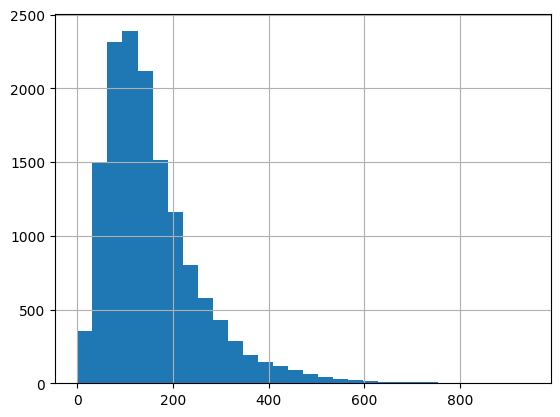

In [10]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [20]:
# Example text classification task
num_classes = len(skills)  # Number of classes in the classification task
hidden_size = int(2/3*len(skills))  # Number of units in the bottleneck layer

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(768, num_hidden)
        self.tanh = torch.nn.Tanh()

        #sigmoid activation function
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.dropout(cls_hs)

        x = self.fc1(x)
        x = self.tanh(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [147]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(skills))
for param in model.bert.parameters():
    param.requires_grad = False
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [148]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


# Training loop
num_epochs = 4

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [118]:
# function to train the model
def train():
    
    model.train()
    total_loss = 0
  
    # empty list to save
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()       
        # get model predictions for the current batch
        outputs = model(sent_id, 
                    token_type_ids=None, 
                    attention_mask=mask, 
                    labels=labels)

        # compute the loss between actual and predicted values
        loss = outputs[0]
        
        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        scheduler.step()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  

    #returns the loss and predictions
    return avg_loss

In [119]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            outputs = model(sent_id, 
                            token_type_ids=None, 
                            attention_mask=mask, 
                            labels=labels)

            # compute the validation loss between actual and predicted values
            loss = outputs[0]

            total_loss = total_loss + loss.item()


    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 


    return avg_loss

NameError: name 'labels' is not defined

In [75]:
counter = 0
for step,batch in enumerate(train_dataloader):
    if step == 0:
        print('0')
        sent_id, mask, labels = batch
        print(len(sent_id[0]))
        print(len(mask))
    counter = counter +1
print(counter)

0
300
16
888


In [167]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(num_epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
    
    #train model
    train_loss = train()
    
    #evaluate model
    valid_loss = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_topskill.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.077
Validation Loss: 0.059

 Epoch 2 / 4
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.059
Validation Loss: 0.058

 Epoch 3 / 4
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.058
Validation Loss: 0.058

 Epoch 4 / 4
  Batch    50  of    191.


KeyboardInterrupt: 

In [33]:
len(test_seq)

4060

In [95]:
skills = removeUnfrequentSkill(all_skills,3010)

text_data = []
label_data = []
for job in data['jobs']:
    job_text = job['requirements_and_role'] + ' ' + job['job_requirements']
    skill_required = [float(0)] * len(skills)
    for skill in job['skills_required']:
        if skill in skills:
            skill_required[skills.index(skill)] = float(1)
    text_data.append(job_text)
    label_data.append(skill_required)

train_text, test_text, train_labels, test_labels = train_test_split(text_data, label_data, test_size=0.4, random_state=42,shuffle=True)
val_text, test_text, val_labels, test_labels = train_test_split(test_text, test_labels, test_size=0.75, random_state=42,shuffle=True)

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

text_data = []
label_data = []
for job in data['jobs']:
    job_text = job['requirements_and_role'] + ' ' + job['job_requirements']
    skill_required = [float(0)] * len(skills)
    for skill in job['skills_required']:
        if skill in skills:
            skill_required[skills.index(skill)] = float(1)
    text_data.append(job_text)
    label_data.append(skill_required)


num_classes = len(skills)  # Number of classes in the classification task
hidden_size = int(2/3*len(skills))  # Number of units in the bottleneck layer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(skills))
for param in model.bert.parameters():
    param.requires_grad = False
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)


# Training loop
num_epochs = 8

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(num_epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
    
    #train model
    train_loss = train()
    
    #evaluate model
    valid_loss = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_20.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    
skills = removeUnfrequentSkill(all_skills,20)

text_data = []
label_data = []
for job in data['jobs']:
    job_text = job['requirements_and_role'] + ' ' + job['job_requirements']
    skill_required = [float(0)] * len(skills)
    for skill in job['skills_required']:
        if skill in skills:
            skill_required[skills.index(skill)] = float(1)
    text_data.append(job_text)
    label_data.append(skill_required)

train_text, test_text, train_labels, test_labels = train_test_split(text_data, label_data, test_size=0.4, random_state=42,shuffle=True)
val_text, test_text, val_labels, test_labels = train_test_split(test_text, test_labels, test_size=0.75, random_state=42,shuffle=True)

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 300,
    pad_to_max_length=True,
    truncation=True
)

## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

text_data = []
label_data = []
for job in data['jobs']:
    job_text = job['requirements_and_role'] + ' ' + job['job_requirements']
    skill_required = [float(0)] * len(skills)
    for skill in job['skills_required']:
        if skill in skills:
            skill_required[skills.index(skill)] = float(1)
    text_data.append(job_text)
    label_data.append(skill_required)


num_classes = len(skills)  # Number of classes in the classification task
hidden_size = int(2/3*len(skills))  # Number of units in the bottleneck layer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(skills))
for param in model.bert.parameters():
    param.requires_grad = False
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)


# Training loop
num_epochs = 8

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(num_epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
    
    #train model
    train_loss = train()
    
    #evaluate model
    valid_loss = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_all.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Epoch 1 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.548
Validation Loss: 0.505

 Epoch 2 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.515
Validation Loss: 0.505

 Epoch 3 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.505
Validation Loss: 0.509

 Epoch 4 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.501
Validation Loss: 0.497

 Epoch 5 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.497
Validation Loss: 0.480

 Epoch 6 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.493
Validation Loss: 0.478

 Epoch 7 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Epoch 1 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.072
Validation Loss: 0.064

 Epoch 2 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.065
Validation Loss: 0.064

 Epoch 3 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.065
Validation Loss: 0.064

 Epoch 4 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.064
Validation Loss: 0.064

 Epoch 5 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.064
Validation Loss: 0.063

 Epoch 6 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    191.

Evaluating...

Training Loss: 0.063
Validation Loss: 0.062

 Epoch 7 / 8
  Batch    50  of    191.
  Batch   100  of    191.
  Batch   150  of    1

In [96]:
len(train_y[0])

1209

In [221]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(skills))
for param in model.bert.parameters():
    param.requires_grad = False
model = model.to(device)

#load weights of best model
path = 'saved_weights_topskill_0.001.pt'
model.load_state_dict(torch.load(path))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))

In [222]:
preds = []
pred_size = 100
# get predictions for test data
with torch.no_grad():
    for i in range(0, len(test_seq),pred_size):
        if i + pred_size < len(test_seq):
            preds_t = model(test_seq[i:i+pred_size].to(device), test_mask[i:i+pred_size].to(device))
            preds.append(preds_t)


In [246]:
output_target = test_y.detach().cpu().numpy()

In [247]:
len(test_y[0])

109

In [248]:
output_target = output_target[:-90]

In [249]:
len(output_target)

6000

In [225]:
output = []
for pred in preds:
    for row in pred[0].detach().cpu().numpy():
        output.append(row)


In [226]:
output = np.array(output)

In [227]:
len(output)

6000

In [7]:
class BERT_test(nn.Module):

    def __init__(self, num_classes):
        super(BERT_test, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        hidden_output = self.tanh(self.hidden_layer(pooled_output))
        logits = self.output_layer(hidden_output)
        probabilities = self.sigmoid(logits)
        return probabilities

In [52]:
model = BERT_test(num_classes)

model = model.to(device)


In [18]:
input_ids = torch.tensor([[  101,  3563, 21312,  2658,  2690,  3677,  2968,  3677,  4363,  2568,
         3289,  3513,  7816, 11100,  6509,  2491, 13307,  6515,  5166, 12725,
         5366,  9975,  4758, 20446,  6026,  5618,  8010,  5676,  6368,  2551,
         2181,  5463,  3180,  3116, 27918,  2562,  6727,  6043,  8853,  2569,
         2824,  7620,  3488,  4113,  7928,  5220,  2833, 12183,  2015,  4511,
        12183,  3253, 11730, 28589,  2136,  2202,  2344,  2833, 19645, 13307,
        12183,  2015,  5676, 28616,  4372,  2173,  4825,  2326, 11178,  4810,
         3188,  3098,  3178,  2326,  2204,  3716, 13307, 12183,  1042,  1038,
         2154,  2154,  3450,  3640,  2968,  5541,  4784,  3189, 19399, 20880,
         7640,  5676,  4113,  9967,  1041,  1043, 23534,  2282,  7759,  2236,
         2191,  2296,  3947,  5676,  7216,  4113, 11186,  2802,  2326,  2552,
         2952,  7126,  2490,  3677,  5676,  4113,  2282,  5571,  2685,  4341,
         6149,  5676,  5204,  6727,  3688,  3309,  2224,  4825,  2326,  2556,
         2802,  2326,  3716,  6368,  7777,  2802,  2994,  5918, 26426,  9031,
         2015,  2440,  2152,  2082,  2495,  6503,  4217, 15032,  2147,  3325,
         2048,  2086,  3325,  3677,  2535,  2714,  4087,  4813,  2204,  3716,
         3136,  4825,  3347,  8853,  2275,  2326,  2804,  3309,  6043,  5352,
         8800,  3716,  4825,  2326,  2204,  3094,  2517,  5287,  2394,  6581,
         4012, 23041,  5555,  4263,  3754,  4800, 10230,  2243,  2147,  4044,
         3082,  8783,  4475,  2089,  3223,  2442,  2583,  3233,  2146,  6993,
         2051,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])  # Example input IDs
attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  # Example attention mask

In [19]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [157]:
preds_test = model(test_seq[40:41], test_mask[40:41])

In [158]:
logits = preds_test.logits
logits.shape

torch.Size([1, 1209])

In [239]:
test_y[0]

tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0.])

In [238]:
test_y.shape

torch.Size([6090, 20])

In [159]:
preds_test

SequenceClassifierOutput(loss=None, logits=tensor([[-5.3989, -3.7136, -4.2537,  ..., -5.3550, -5.2497, -4.7844]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [160]:
logits = logits.detach().cpu().numpy()

In [161]:
logits

array([[-5.398909 , -3.7136133, -4.2536755, ..., -5.354964 , -5.249655 ,
        -4.784443 ]], dtype=float32)

In [194]:
def findThreshold(output, expected_num_skill):
    threshold = []
    for row in output:
        sorted_list = list(row)
        sorted_list.sort()
        threshold.append(sorted_list[-1*expected_num_skill])
    return sum(threshold) / len(threshold)

In [230]:
avg_skill = []
for row in output_target:
    avg_skill.append(sum(row)) 

In [229]:
sum(avg_skill)/len(avg_skill)

5.499333333333333

In [231]:
findThreshold(output,6)

-3.1779351956645647

In [197]:
def formatOutput(output, threshold):
    for i in range(len(output)):
        for j in range(len(output[i])):
            if output[i][j] > threshold:
                output[i][j] = float(1)
            else:
                output[i][j] = float(0)
    return output

In [275]:
output = formatOutput(output,-3.5)

In [276]:
preds_rotate = np.rot90(output, k=3)
labels_rotate = np.rot90(output_target, k=3)

In [251]:
len(labels_rotate)

109

In [277]:
precision_list = []
recall_list = []
for i in range(len(preds_rotate)):
    precision_list.append(precision_score(labels_rotate[i], preds_rotate[i]))
    recall_list.append(recall_score(labels_rotate[i], preds_rotate[i]))

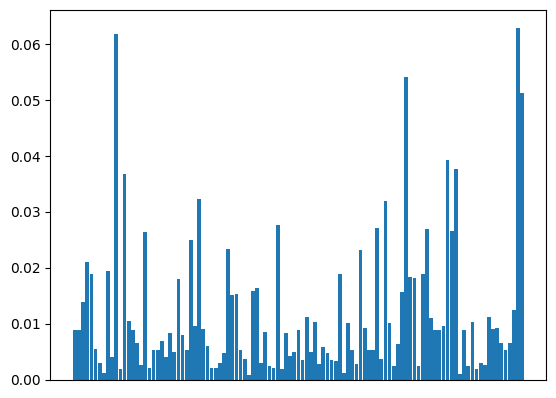

In [278]:
plt.bar(skills, precision_list, color ='tab:blue',
        width = 0.9)
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [269]:
precision_list

[0.008833333333333334,
 0.008833333333333334,
 0.013833333333333333,
 0.021,
 0.018833333333333334,
 0.0055,
 0.003,
 0.0011666666666666668,
 0.0195,
 0.004,
 0.06183333333333333,
 0.0018333333333333333,
 0.036833333333333336,
 0.0105,
 0.008833333333333334,
 0.0065,
 0.0026666666666666666,
 0.026333333333333334,
 0.002,
 0.005333333333333333,
 0.005333333333333333,
 0.006833333333333334,
 0.004,
 0.008333333333333333,
 0.004833333333333334,
 0.018,
 0.008,
 0.005333333333333333,
 0.025,
 0.0095,
 0.03233333333333333,
 0.009,
 0.006,
 0.002,
 0.002,
 0.003,
 0.004666666666666667,
 0.023333333333333334,
 0.015166666666666667,
 0.015333333333333332,
 0.005333333333333333,
 0.0036666666666666666,
 0.0008333333333333334,
 0.015833333333333335,
 0.01633333333333333,
 0.003,
 0.0085,
 0.0023333333333333335,
 0.002,
 0.027666666666666666,
 0.0018333333333333333,
 0.008333333333333333,
 0.004166666666666667,
 0.005,
 0.008833333333333334,
 0.0035,
 0.011166666666666667,
 0.004833333333333334,


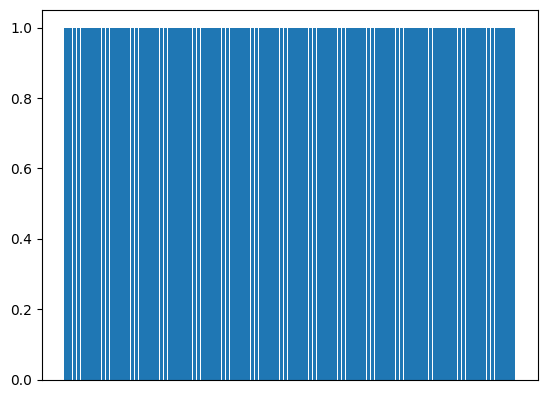

In [279]:
plt.bar(skills, recall_list, color ='tab:blue',
        width = 0.9)
        
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [280]:
sum(precision_list)/len(precision_list)

0.011951070336391433

In [281]:
sum(recall_list)/len(recall_list)

1.0

<Axes: >

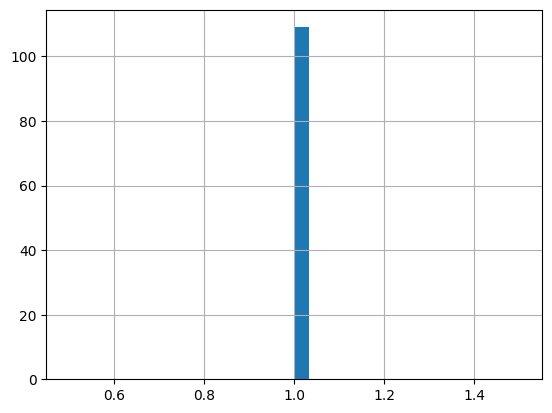

In [273]:
pd.Series(recall_list).hist(bins = 30)

In [55]:
recall_score([float(1),float(0),float(1)],[float(0),float(0),float(1)])

0.5

In [162]:
sorted_list = list(logits[0])

In [163]:
sorted_list.sort()

In [164]:
sorted_list[-20]

-1.7306391

In [120]:
min(list(logits[0]))

-5.520734

In [111]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [118]:
counter = 0
for i in logits[0]:
    if i > -2:
        print(i)
        print(skills[counter])
        counter = counter + 1

-1.8802754
Power Plants
-1.8426442
Accounts Payable
-1.5002093
Tax
-0.30236483
Asset Allocation
-0.15859808
Malware Analysis
-1.0978402
.NET
-1.1819309
Cpr Certified
-1.4262843
Visual Effects
0.8086141
Litigation Support
-1.533456
Data Center
-0.7408858
Executive Protection
-1.117445
Sustainable Development
-1.3168218
Windows Server
-1.6876146
JIRA
0.13206923
Dreamweaver
-1.1059632
Criminal Law
-1.8771856
SAP FI
-0.9058267
Dispute
-1.8132976
Cash Flow
-0.6217861
Programming
-0.19807725
CAD
-1.7657413
Westlaw
-1.8062503
Financials
-1.6294932
Photography
-1.0209919
HRIS
-1.9479595
IDS
-1.6590565
Call Centers


In [106]:
counter = 0
for i in test_y[0]:
    if i > 0:
        print(i)
        print(skills[counter])
        counter = counter + 1

tensor(1.)
Power Plants
tensor(1.)
Accounts Payable
tensor(1.)
Tax
tensor(1.)
Asset Allocation
tensor(1.)
Malware Analysis
tensor(1.)
.NET
tensor(1.)
Cpr Certified
tensor(1.)
Visual Effects
tensor(1.)
Litigation Support
tensor(1.)
Data Center
tensor(1.)
Executive Protection
tensor(1.)
Sustainable Development
tensor(1.)
Windows Server
tensor(1.)
JIRA
tensor(1.)
Dreamweaver
tensor(1.)
Criminal Law
tensor(1.)
SAP FI
tensor(1.)
Dispute
tensor(1.)
Cash Flow
tensor(1.)
Programming


In [117]:
def averagePrecisionRecall(preds, labels, threshold):
    preds_rotate = np.rot90(preds, k=3)
    labels_rotate = np.rot90(labels, k=3)

    for i in range(len(preds_rotate)):
        for j in range(len(preds_rotate[0])):
            if preds_rotate[i][j] > threshold:
                preds_rotate[i][j] = float(1)
            else:
                preds_rotate[i][j] = float(0)

    precision_list = []
    recall_list = []
    for i in range(num_classes):
        precision_list.append(precision_score(labels_rotate[i], preds_rotate[i]))
        recall_list.append(recall_score(labels_rotate[i], preds_rotate[i]))
    print("Precision: ",sum(precision_list)/len(precision_list))
    print("Recall: ",sum(recall_list)/len(recall_list))
    return precision_list, recall_list

In [122]:
preds_rotate = np.rot90(preds, k=3)
labels_rotate = np.rot90(test_labels, k=3)

In [129]:

skill_sum = []
for skill in labels_rotate:
    skill_sum.append(sum(skill))

pred_sum = []
for skill in preds_rotate:
    pred_sum.append(sum(skill))

In [133]:
pred_sum.count(0)

60

<Axes: >

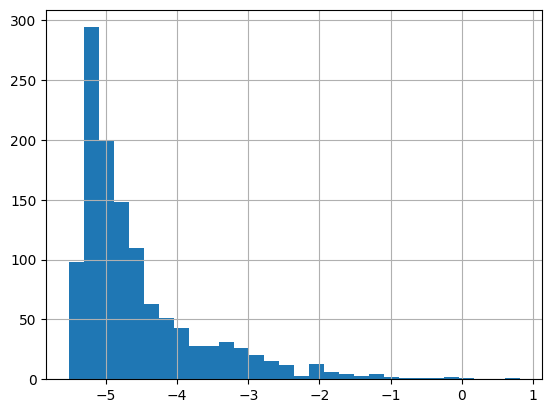

In [108]:
pd.Series(list(logits)).hist(bins = 30)

In [119]:
precision_list, recall_list = averagePrecisionRecall(preds, test_labels, 0.5)

C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

Precision:  0.014061082527985064
Recall:  0.00450262371218577


C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s222lin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-d

In [114]:
print(max(precision_list))
print(max(recall_list))

1.0
0.9363776295536173
